### Setting up GPU memory growth to avoid OOM errors

In [1]:
import tensorflow as tf

# avoid oom errors by setting GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.set_logical_device_configuration(gpu, [tf.config.LogicalDeviceConfiguration(memory_limit=2048)])

### Data Loading

In [2]:
(train_img, train_label), (test_img, test_label) = tf.keras.datasets.mnist.load_data()

In [3]:
print('Total image for training:', len(train_img))
print('Total image for testing:', len(test_img))

Total image for training: 60000
Total image for testing: 10000


In [4]:
print('Total label for training:', len(train_label))
print('Total label for testing:', len(test_label))

Total label for training: 60000
Total label for testing: 10000


### Get 1 image from each class for training

In [5]:
import numpy as np

train_idx = np.unique(train_label, return_index=True)[1].tolist()
train_images = train_img[train_idx]
train_labels = train_label[train_idx]

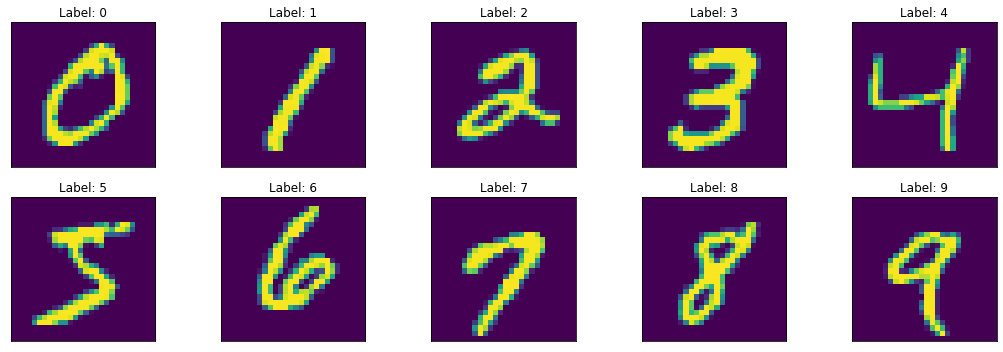

In [6]:
import PIL
from matplotlib import pyplot as plt

_, axs = plt.subplots(2, 5, figsize=(15,5))
for i in range(10):
    ax = axs[i//5, i%5]
    img = PIL.Image.fromarray(train_images[i])
    ax.imshow(img)
    ax.set_title('Label: {}'.format(train_labels[i]))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fname = 'dataset/train/' + str(train_labels[i]) + '.jpg'
    img.save(fname)
plt.tight_layout()
plt.show()

### Get Data for testing

In [7]:
test_idx = np.unique(test_label, return_index=True)[1].tolist()
test_images = test_img[test_idx]
test_labels = test_label[test_idx]

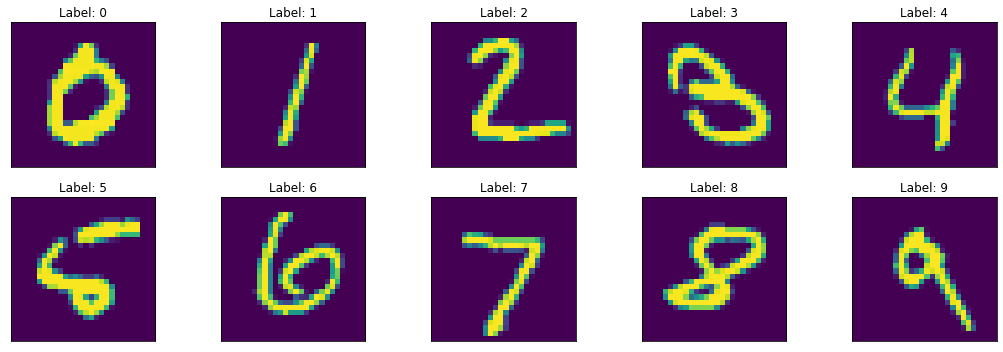

In [8]:
_, axs = plt.subplots(2, 5, figsize=(15,5))
for i in range(10):
    ax = axs[i//5, i%5]
    img = PIL.Image.fromarray(test_images[i])
    ax.imshow(img)
    ax.set_title('Label: {}'.format(test_labels[i]))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fname = 'dataset/test/' + str(test_labels[i]) + '.jpg'
    img.save(fname)
plt.tight_layout()
plt.show()

### Modeling

In [9]:
from keras import layers
from keras import Sequential
from tensorflow.keras.optimizers import SGD

model = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer=SGD(learning_rate=.01), loss='categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 100)               540900    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 542,806
Trainable params: 542,806
Non-trainable params: 0
__________________________________________________

### Triplet Loss

In [10]:
def triplet_loss(y_true, yhat, alpha=.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = yhat[0], yhat[1], yhat[2]
    
    # compute distance between anchor and positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    
    # compute distance between anchor and negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    
    # subtract the distance and add alpha
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    
    # take the maximum of basic_loss and 0.0 and sum training examples
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    return loss

In [11]:
def img_to_tensor(image, model):
    img = tf.keras.preprocessing.image.load_img(image, target_size=(28,28))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

### Creating Database

In [12]:
database = {}
for label in train_labels:
    img = 'dataset/train/' + str(label) + '.jpg'
    database[str(label)] = img_to_tensor(img, model)

In [13]:
def classify(image, database, model):
    """
    Implements digit recognition.
    
    Arguments:
        image -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- your Inception model instance in Keras
    
    Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        label -- string, the name prediction for the person on image_path
    """
    
    # compute target "tensor" for image
    encoding = img_to_tensor(image, model)
    
    # initialize "min_dist" to a large value
    min_dist = 100
    
    for (name, tensor) in database.items():
        # compute l2 distance
        dist = np.linalg.norm(encoding - tensor)
        
        if dist < min_dist:
            min_dist = dist
            label = name
    
    if min_dist > .7:
        print('Not in the database')
    else:
        print('Prediction: {}, the distance is {}'.format(str(label), str(min_dist)))
    return min_dist, label

Prediction: 6, the distance is 0.43202892


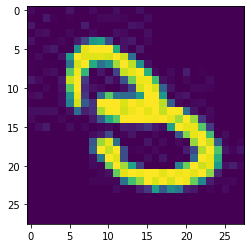

In [20]:
test = 'dataset/test/3.jpg'
classify(test, database, model)
temp = PIL.Image.open(test)
plt.imshow(temp)
plt.show()